In [56]:
# from google.colab import drive
# drive.mount('/content/drive')

Import Dataset Lumos5G from https://ieee-dataport.org/open-access/lumos5g-dataset

In [57]:
# Load the dataset
# file_path = '/content/drive/My Drive/Lumos5G/Lumos5G-v1.0.csv'
file_path = '/Users/KU1247/Desktop/active_learning_code/Lumos5G-v1.0.csv'

In [58]:
#Active learning parameters
###########################################
###########################################
iterations = 100 #number of iterations for active learning, where in each iteration we query new samples.
n_samples = 4 #number of samples to be quiered in each iteration
parameter_for_outlier_method = 1.5 #parameter for removing outlier in uncertainty sampling.
starting_percentage = 0.2 #percentage of how many labeled samples to start with in training. 
#model and training hyperparameters
neurons = 256 #number of neurons in last layer
epochs = 100 # epochs
lr = 0.008 #learning rate
dropout = 0.3
batch_size = 128
n_iterations = 35 #number of iterations in Bayesian Inference.

#early stopping
patience = 4 #patience for early stopping of callback.
min_delta = 1 #tolerance in early stopping.

folder_from = None #whether to start from existing training set or scratch.
folder_to = 'past_runs/run9_passive' #where to save results and logs.
base_dir = '/Users/KU1247/Desktop/active_learning_code/' #change this to your own directory

experiment = 'passive'  # 'active' or 'passive' #the code runs active or passive only at a time.
###########################################
###########################################
###########################################
###########################################

In [59]:
import pandas as pd



lumos5g_df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
lumos5g_df.head()


,run_num,seq_num,abstractSignalStr,latitude,longitude,movingSpeed,compassDirection,nrStatus,lte_rssi,lte_rsrp,lte_rsrq,lte_rssnr,nr_ssRsrp,nr_ssRsrq,nr_ssSinr,Throughput,mobility_mode,trajectory_direction,tower_id
0,1,1.0,2,44.975314,-93.259316,0.094889,150,NOT_RESTRICTED,-61.0,-94,-14.0,2.147484e+09,NaN,NaN,NaN,78,driving,CW,16
1,1,2.0,2,44.975311,-93.259311,0.876634,117,NOT_RESTRICTED,-61.0,-94,-14.0,2.147484e+09,NaN,NaN,NaN,117,driving,CW,16
2,1,3.0,2,44.975305,-93.259292,2.225798,113,NOT_RESTRICTED,-61.0,-94,-14.0,2.147484e+09,NaN,NaN,NaN,110,driving,CW,16
3,1,4.0,2,44.975293,-93.259258,3.180726,114,NOT_RESTRICTED,-59.0,-95,-16.0,2.147484e+09,NaN,NaN,NaN,108,driving,CW,16
4,1,5.0,2,44.975278,-93.259214,3.751234,115,NOT_RESTRICTED,-59.0,-95,-16.0,2.147484e+09,NaN,NaN,NaN,100,driving,CW,16


Lumos5G Data Pre-processing

In [60]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Columns to be dropped or imputed
columns_to_drop = ['seq_num']  # Dropping sequence number (not relevant to training)
columns_to_impute = ['nr_ssRsrp', 'nr_ssRsrq', 'nr_ssSinr']  # Impute missing values in 5G signal strength columns

# Categorical and numerical columns
categorical_columns = ['nrStatus', 'mobility_mode', 'trajectory_direction']
numerical_columns = ['abstractSignalStr', 'latitude', 'longitude', 'movingSpeed',
                     'compassDirection', 'lte_rssi', 'lte_rsrp', 'lte_rsrq', 'lte_rssnr',
                     'nr_ssRsrp', 'nr_ssRsrq', 'nr_ssSinr']

# Define the preprocessing pipeline for numerical features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Impute missing values with zero
    ('scaler', StandardScaler())  # Normalize the numerical features
])

# Define the preprocessing pipeline for categorical features
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical variables into dummy/indicator variables
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ],
    remainder='drop'  # Columns not listed will be dropped
)

# Separate features and target variable
X = lumos5g_df.drop(['Throughput', 'seq_num', 'tower_id'], axis=1)  # Drop 'seq_num' and 'tower_id' as well
y = lumos5g_df['Throughput']

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# The shape of preprocessed features
# y.shape
# y.info()

In [61]:
import numpy as np

def create_time_dataset(matrix,labels, n_steps=20):
    X, y = [], []
    temp = labels.to_numpy()
    for i in range(len(matrix) - n_steps * 2 + 1):  # Adjusted range
        # Reshape data from [samples, timesteps] into [samples, timesteps, features] for X
        X.append(matrix[i:(i + n_steps), :])
        # Adjusted to include the next 20 steps as the target
        y.append(temp[(i + n_steps):(i + n_steps * 2)])

    return np.array(X), np.array(y)

X_time_preprocessed, y_time = create_time_dataset(X_preprocessed,y)
print(f"Input shape: {X_time_preprocessed.shape}")  # Each sample in X contains 20 steps, each with 19 features
print(f"Target shape: {y_time.shape}")  # Each target in y contains the next 20 steps, each with 19 features

Input shape: (68079, 20, 19)
Target shape: (68079, 20)


In [62]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization

# Since our data is not in sequence format for each sample, we reshape it to (-1, 1, features) to fit the LSTM input requirement
X_reshaped = X_time_preprocessed.copy() # X_time_preprocessed.reshape((X_time_preprocessed.shape[0], 1, X_time_preprocessed.shape[1]))
y = y_time.copy()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

Active Learning

In [63]:
'''
Callback function for MC_dropout. To use early stopping based on the prediction performance on the validation set, we need to create a custom callback, where we run inference multiple times and take the average.
'''

from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
import numpy as np

class MC_DropoutCallback(Callback):
    def __init__(self, validation_data, mc_runs=10, patience=7, min_delta=1):
        super().__init__()
        self.validation_data = validation_data  # A tuple (X_val, y_val)
        self.mc_runs = mc_runs  # Number of Monte Carlo runs
        self.patience = patience  # How many epochs to wait after last time validation error improved.
        self.min_delta = min_delta  # Minimum change in the monitored quantity to qualify as an improvement.
        self.wait = 0  # How many epochs we have waited without improvement.
        self.best_score = None  # Best validation error score
        self.best_weights = None  # Store the best model weights

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        X_val, y_val = self.validation_data
        mc_predictions = []

        # Perform MC runs
        for _ in range(self.mc_runs):
        #     preds = self.model.predict(X_val, verbose=0)
        #     mc_predictions.append(preds)

        # mc_predictions = np.array(mc_predictions)
        # mc_mean_predictions = np.mean(mc_predictions, axis=0)
        # mc_mean_predictions = np.squeeze(mc_mean_predictions, axis=-1)
        # # Here you could compute additional metrics like variance or standard deviation
        # # For simplicity, we'll just log the mean prediction's MSE as an example
        # rmse = np.sqrt(np.mean((mc_mean_predictions - y_val) ** 2))
            preds = self.model.predict(X_val, verbose=0)
            mc_predictions.append(preds)

        # Convert list of TensorFlow tensors to a single TensorFlow tensor
        mc_predictions = tf.stack(mc_predictions)
        mc_mean_predictions = tf.reduce_mean(mc_predictions, axis=0)
        mc_mean_predictions = tf.squeeze(mc_mean_predictions, axis=-1)

        # Calculate RMSE using TensorFlow operations
        mse = tf.reduce_mean(tf.square(mc_mean_predictions - y_val))
        rmse = tf.sqrt(mse)

        # Update logs
        logs['val_mc_rmse'] = rmse
        print(f"Epoch {epoch + 1}: Validation MC MSE: {rmse:.4f}")

        # Early Stopping Check
        if self.best_score is None:
            self.best_score = rmse
            self.best_weights = self.model.get_weights()
        elif rmse < self.best_score - self.min_delta:
            self.best_score = rmse
            self.best_weights = self.model.get_weights()
            self.wait = 0  # reset wait counter since we improved
        else:
            self.wait += 1  # increment the wait counter
            if self.wait >= self.patience:
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

        # You can also log the best RMSE seen so far
        logs['best_val_mc_rmse'] = self.best_score

# Usage remains the same


9803
(20, 19)
Epoch 1/2


/Users/KU1247/anaconda3/envs/active_learning/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1: Validation MC MSE: 447.7693
77/77 - 10s - 134ms/step - loss: 1282729.5000 - val_loss: 213273.5781 - val_mc_rmse: 447.7693 - best_val_mc_rmse: 447.7693
Epoch 2/2
Epoch 2: Validation MC MSE: 409.2101
77/77 - 9s - 118ms/step - loss: 186068.7969 - val_loss: 179729.3438 - val_mc_rmse: 409.2101 - best_val_mc_rmse: 409.2101
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Passive Learning RMSE: 406.2000334305869
0


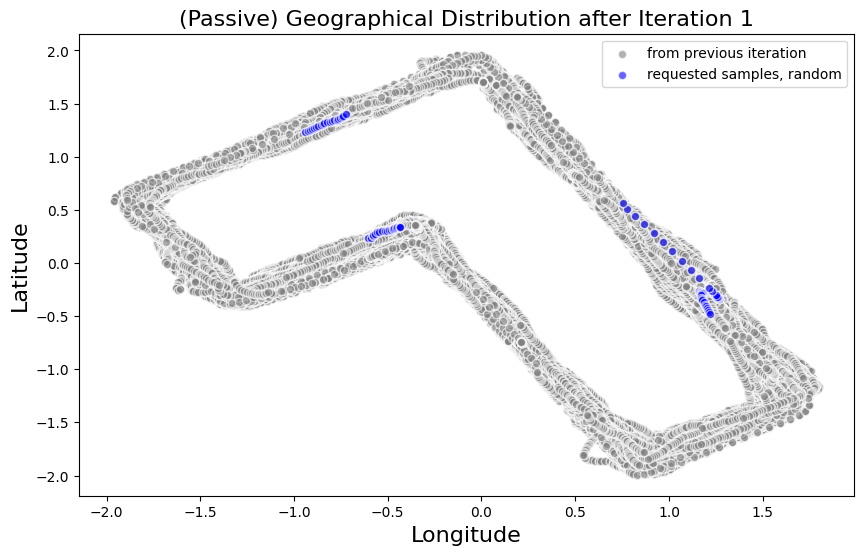

Iteration 1/1 completed, model retrained with 9807 samples.
Parameters logged to /Users/KU1247/Desktop/active_learning_code/code_to_submit/past_runs/run9_passive/experiment_log.txt


In [64]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Flatten
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow.keras.backend as K
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model  # Ensure import is correctly placed
import os 



dir_to_create = f'{base_dir}{folder_to}/' 
dir_to_create_experiment_figures =  f'{base_dir}{folder_to}/{experiment}_iterations/'
# Create the directory if it does not exist
os.makedirs(dir_to_create, exist_ok=True)
os.makedirs(dir_to_create_experiment_figures, exist_ok=True)


#  function to load .npy data from a specific path with a variable directory component
def load_datasets(filename_prefix, run_directory, base_dir='/Users/KU1247/Desktop/active_learning_code/'):
    # Construct the full directory path
    load_dir = f'{base_dir}{run_directory}/'

    # Load the datasets
    X = np.load(f'{load_dir}{filename_prefix}_X.npy')
    y = np.load(f'{load_dir}{filename_prefix}_y.npy')

    return X, y

#  function to load a model from a specific path with a variable directory component
def load_model_from_file(model_name, custom_objects, run_directory, base_dir='/Users/KU1247/Desktop/active_learning_code/'):
    # Construct the full directory path
    load_dir = f'{base_dir}{run_directory}/'

    # Load the model
    return load_model(f'{load_dir}{model_name}.h5', custom_objects=custom_objects)

# function to log parameters used in the experiment. 
def log_parameters(params_dict, log_filename, log_directory):
    """
    Logs given parameters to a specified text file.

    :param params_dict: A dictionary containing parameter names and values.
    :param log_filename: The name of the file to write logs to.
    :param log_directory: The directory where the log file will be saved.
    """
    # Ensure the directory exists
    os.makedirs(log_directory, exist_ok=True)

    # Full path for the log file
    log_path = os.path.join(log_directory, log_filename)

    # Write parameters to the file
    with open(log_path, 'a') as log_file:  # Using 'a' to append to the file if it exists
        log_file.write('Parameter Log:\n')
        for key, value in params_dict.items():
            log_file.write(f"{key}: {value}\n")
        log_file.write('\n')  # Add a newline to separate different logging events

    print(f"Parameters logged to {log_path}")


# Custom RMSE metric
def rmse(y_true, y_pred):
    y_pred = np.squeeze(y_pred, axis=-1)
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Function to evaluate model
def evaluate_model(model, X_test, y_test, n_iterations=2):
    predictions = [model.predict(X_test) for _ in range(n_iterations)]
    predictions = np.asarray(predictions)

    y_pred = predictions.mean(axis=0)

    y_pred = np.squeeze(y_pred, axis=-1)

    mse = mean_squared_error(y_test, y_pred)

    return mse

# Function to estimate uncertainty of the model's predictions using MC Dropout
def estimate_uncertainty(model, X_unlabeled, n_iterations=2):

    predictions = [model.predict(X_unlabeled) for _ in range(n_iterations)]
    predictions = np.asarray(predictions)

    variances = predictions.var(axis=0)
    variances = np.squeeze(variances, axis=-1)

    variances = np.max(variances, axis=-1) #.max is a strategy, we can use .mean as well, or some other more sophisticated approach.

    return variances


# Custom Dropout layer that is active at inference time
class MCDropout_active(Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)
        # return super().call(inputs, training=True, noise_shape=(inputs.shape[0], 1, inputs.shape[2]))


# # Define the model architecture with MC Dropout
def create_model_active(input_shape):
    # print(input_shape)
    model = Sequential([
        # Flatten(input_shape=(20, 19)),
        LSTM(neurons, activation='relu', return_sequences=False ,input_shape=input_shape),
        # LSTM(128, activation='relu', return_sequences=False ),
        MCDropout_active(dropout),
        RepeatVector(20),  # Prepares the decoder to output 20 time steps


        # Decoder
        TimeDistributed(Dense(256)),
        MCDropout_active(dropout),
        TimeDistributed(Dense(64)),
        MCDropout_active(dropout),
        # TimeDistributed(Dense(128)),  # Assuming you want to predict 19 features at each time step
        # MCDropout_active(dropout),
        TimeDistributed(Dense(1))  # Assuming you want to predict 19 features at each time step

    ])
    optimizer = Adam(learning_rate=lr)  # You can change the learning rate here
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


# function to select samples with highest uncertainty up to n_samples
def select_samples_by_uncertainty(variances, n_samples):
    # Sort the variances and select the top n_samples indices
    idx = np.argsort(variances)[-n_samples:]
    return idx

# function to plot samples based on latitude and longitude
def plot_geographical_distribution(X,X_new,folder_to, experiment = 'active', iteration=1, title="Geographical Distribution"):
    base_dir = '/Users/KU1247/Desktop/active_learning_code/'
    dir_to_create = f'{base_dir}{folder_to}/'
    dir_to_create_experiment_figures =  f'{base_dir}{folder_to}/{experiment}_iterations/'
    dir_to_create_experiment_figures = dir_to_create_experiment_figures + str(iteration) + '.png'

    print(iteration)
    """
    Plot the geographical distribution of data points.

    Parameters:
    - X: A NumPy array containing the samples with longitude and latitude as the first two features.
    - title: A string for the plot title.
    """
    fontsize = 16
    # Assuming the first two features in X are longitude and latitude
    longitude = X[:, 0]  # Adjust index if necessary
    latitude = X[:, 1]  # Adjust index if necessary

    plt.figure(figsize=(10, 6))
    plt.scatter(longitude, latitude, alpha=0.6, edgecolors='w', color='gray', label='from previous iteration')
    if(experiment == 'passive'):
    # plt.plot(longitude, latitude, '-', label='Label', color='blue')  # '-o' creates lines and marks the points
        plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.6, edgecolors='w', color='blue', label='requested samples, random')
        # plt.scatter(X_new2[:, 0], X_new2[:, 1], alpha=0.6, edgecolors='w', color='red', label='requested sample, random')
    elif(experiment == 'active'):
        plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.6, edgecolors='w', color='blue', label='requested samples, uncertainty')
        # plt.scatter(X_new2[:, 0], X_new2[:, 1], alpha=0.6, edgecolors='w', color='red', label='requested sample, random')

    plt.title(title, fontsize=fontsize)
    plt.xlabel('Longitude', fontsize=fontsize)
    plt.ylabel('Latitude', fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.grid(False)
    plt.legend()
    plt.savefig(dir_to_create_experiment_figures)
    plt.show()


# def plot_tsne_projection(X1, title="t-SNE Projection"):
#     """
#     Plot the t-SNE projection of the given high-dimensional data.

#     Parameters:
#     - X: High-dimensional data to be projected and plotted. It should be reshaped if necessary.
#     - title: Title for the plot.
#     """
#     tsne = TSNE(n_components=2, random_state=42)
#     X_tsne = tsne.fit_transform(X)

#     plt.figure(figsize=(10, 6))
#     plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5)
#     plt.title(title)
#     plt.xlabel('t-SNE Feature 1')
#     plt.ylabel('t-SNE Feature 2')
#     plt.show()


# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_rmse',  # Monitor the validation loss
    min_delta=1,  # Minimum change to qualify as an improvement
    patience=15,  # Stop after 10 epochs without improvement
    mode='min',  # Minimize the monitored quantity
    verbose=1,  # Print messages when stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

def passive_learning_loop(X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_val,y_val, iterations, n_samples):

    input_shape = (X_labeled.shape[1], X_labeled.shape[2])
    print(input_shape)
    model = create_model_active(input_shape)

    performance = []
    for iteration in range(iterations):
      # model = create_model_active(input_shape)
      mc_dropout_callback = MC_DropoutCallback(validation_data=(X_val, y_val), mc_runs=n_iterations, patience=patience, min_delta=min_delta)
        
      if(np.mod(iteration,10) == 0 ):
        model = create_model_active(input_shape)

      history = model.fit(
          X_labeled,
          y_labeled,
          epochs=epochs,
          verbose=2,
          callbacks=[mc_dropout_callback],
          validation_data=(X_val, y_val),  # Assuming you have enough data to use a portion as validation
          batch_size=batch_size
      )

      mse_passive = evaluate_model(model, X_test, y_test, n_iterations)
      # print(f"Active Learning MSE: {mse_active}")
      rmse_passive = np.sqrt(mse_passive)
      print(f"Passive Learning RMSE: {rmse_passive}")
      performance.append(rmse_passive)

      if len(X_unlabeled) == 0:
        print("No more unlabeled data available.")
        break

      n_samples = min(n_samples, len(X_unlabeled))


      selected_indices = np.random.choice(range(len(X_unlabeled)), size=n_samples, replace=False)
      # Use a boolean mask to manage selections and deletions
      mask = np.zeros(len(X_unlabeled), dtype=bool)
      mask[selected_indices] = True
      # Select samples to move from unlabeled to labeled using the mask
      X_to_label = X_unlabeled[mask]
      y_to_label = y_unlabeled[mask]

      # Add selected samples to the labeled set
      X_labeled = np.concatenate([X_labeled, X_to_label], axis=0)
      y_labeled = np.concatenate([y_labeled, y_to_label], axis=0)
      # Remove the selected samples from the unlabeled set using inverse mask

      features_indices = [1,2]
      # Assuming you're dealing with reshaped data for LSTM, reshape back if necessary to plot
      X_labeled_for_plot = X_labeled.reshape(-1, X_labeled.shape[-1])[:, features_indices]
      X_to_label_for_plot = X_to_label.reshape(-1, X_to_label.shape[-1])[:, features_indices]
      plot_geographical_distribution(X_labeled_for_plot,X_to_label_for_plot,folder_to,experiment, iteration, title=f"(Passive) Geographical Distribution after Iteration {iteration + 1}")

      X_unlabeled = X_unlabeled[~mask]
      y_unlabeled = y_unlabeled[~mask]


      print(f"Iteration {iteration + 1}/{iterations} completed, model retrained with {len(X_labeled)} samples.")
    return X_labeled, y_labeled, X_unlabeled, y_unlabeled, performance, model


def active_learning_loop(X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_val,y_val, iterations, n_samples):


    input_shape = (X_labeled.shape[1], X_labeled.shape[2])


    # model = create_model_active(input_shape)
    # model = load_model_from_file('active_learning_model',custom_objects={'MCDropout_active': MCDropout_active})

    performance = []

    for iteration in range(iterations):
        # model = create_model_active(input_shape)
        if(np.mod(iteration,10) == 0 ):
            # lr = 0.05
            print('creating a new model')
            model = create_model_active(input_shape)
        

        mc_dropout_callback = MC_DropoutCallback(validation_data=(X_val, y_val), mc_runs=n_iterations, patience=patience, min_delta=min_delta)


        history = model.fit(
            X_labeled,
            y_labeled,
            epochs=epochs,
            verbose=2,
            callbacks=[mc_dropout_callback],
            validation_data=(X_val, y_val),  # Assuming you have enough data to use a portion as validation
            batch_size=batch_size
        )

        mse_active = evaluate_model(model, X_test, y_test, n_iterations)
        # print(f"Active Learning MSE: {mse_active}")
        rmse_active = np.sqrt(mse_active)
        
        
        performance.append(rmse_active)
        # print("\n\n")
        if len(X_unlabeled) == 0:
            print("No more unlabeled data available.")
            break

        # Estimate the uncertainty of predictions for the unlabeled data
        variances = estimate_uncertainty(model, X_unlabeled, n_iterations)

        # Step 1 & 2: Calculate Q1, Q3, and IQR
        Q1 = np.percentile(variances, 10)
        Q3 = np.percentile(variances, 75)
        IQR = Q3 - Q1

        
        # Step 3: Determine the upper bound for non-outliers
        upper_bound = Q3 + parameter_for_outlier_method * IQR

        # Step 4: Select variances below the upper bound (thus not outliers) but still relatively large
        # This example selects variances greater than Q1 (to focus on larger variances) and less than the upper bound (to exclude outliers)
        selected_variances = variances[(variances > Q1) & (variances < upper_bound)]
        # Length of the original variances array
        original_length = len(variances)

        # Create a new array filled with zeros of the same length as the original variances array
        padded_variances = np.zeros(original_length)

        # Copy the selected_variances into the beginning of the padded_variances array
        padded_variances[:len(selected_variances)] = selected_variances

        variances = padded_variances

        print("\n\nmean uncertainty is %f\n\n" %np.mean(variances))
        print(f"Active Learning RMSE: {rmse_active}")





        
        print("Shape of X_unlabeled", X_unlabeled.shape)
        
        print("length of variances", len(variances))
        print("length of unlabeled", len(X_unlabeled)) 
        # print('length of unlabeled', len(X_unlabeled))
        # selected_indices_2 = core_set_selection(X_unlabeled, n_samples)

        selected_indices_2 = select_samples_by_uncertainty(variances, n_samples) # select_samples_by_uncertainty_and_diversity(X_unlabeled, variances, n_samples)

        print(selected_indices_2.shape)
        print("selected indices", selected_indices_2)
        # selected_indices_2 = np.random.choice(range(len(X_unlabeled)), size=n_samples, replace=False)
        mask2 = np.zeros(len(X_unlabeled), dtype=bool)
        mask2[selected_indices_2] = True
        # print(selected_indices_2)
        # Use a boolean mask to manage selections and deletions
        # Select samples to move from unlabeled to labeled using the mask
        X_to_label_2 = X_unlabeled[mask2]
        y_to_label_2 = y_unlabeled[mask2]

        # Add selected samples to the labeled set
        X_labeled = np.concatenate([X_labeled, X_to_label_2], axis=0)
        y_labeled = np.concatenate([y_labeled, y_to_label_2], axis=0)
        # Remove the selected samples from the unlabeled set using inverse mask
        X_unlabeled = X_unlabeled[~mask2]
        y_unlabeled = y_unlabeled[~mask2]






        features_indices = [1,2]
        # Assuming you're dealing with reshaped data for LSTM, reshape back if necessary to plot
        X_labeled_for_plot = X_labeled.reshape(-1, X_labeled.shape[-1])[:, features_indices]
        # X_to_label_for_plot_1 = X_to_label_1.reshape(-1, X_to_label_1.shape[-1])[:, features_indices]
        X_to_label_for_plot_2 = X_to_label_2.reshape(-1, X_to_label_2.shape[-1])[:, features_indices]

        plot_geographical_distribution(X_labeled_for_plot,X_to_label_for_plot_2,folder_to, experiment,iteration, title=f"(Active) Geographical Distribution after Iteration {iteration + 1}")

        # Here we assume the original shape had features in the last dimension
        # X_labeled_for_tsne = X_labeled.reshape(-1, X_labeled.shape[-1])
        # Plot t-SNE projection
        # plot_tsne_projection(X_labeled_for_tsne, title=f"t-SNE Projection after Iteration {iteration + 1}")


        print(f"Iteration {iteration + 1}/{iterations} completed, model retrained with {len(X_labeled)} samples.")

    return model, len(X_labeled), performance, X_labeled, y_labeled, X_unlabeled, y_unlabeled

# split into initial training and validation datasets
X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, test_size=0.9, random_state=48)
# Split into initial labeled and unlabeled datasets
# X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_reshaped, y, test_size=0.90, random_state=45)


if(folder_from is None): # Split into initial labeled and unlabeled datasets
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_train, y_train, test_size=1-starting_percentage, random_state=3)
else: #load data (labeled and unlabeled) from folder.
    name_tmp = experiment + '_labeled_dataset'
    X_labeled, y_labeled = load_datasets(name_tmp, folder_from)
    name_tmp = experiment + '_unlabeled_dataset'
    X_unlabeled, y_unlabeled = load_datasets('active_unlabeled_dataset', folder_from)

length_X_labeled_initial = len(y_labeled)
print(length_X_labeled_initial)


y_labeled = tf.cast(y_labeled, tf.float32)
y_unlabeled = tf.cast(y_unlabeled, tf.float32)

y_labeled = y_labeled.numpy()
y_unlabeled = y_unlabeled.numpy()

# print(y_labeled.shape)

# Number of samples to 'label' in each iteration
# Proceed with your pre-defined split and model initialization
if(experiment == 'active'):
    model, num_samples_labeled, performance, X_labeled, y_labeled, X_unlabeled, y_unlabeled = active_learning_loop(X_labeled, y_labeled, X_unlabeled, y_unlabeled,X_val,y_val, iterations, n_samples)
elif(experiment == 'passive'):
    X_labeled, y_labeled, X_unlabeled, y_unlabeled, performance, model = passive_learning_loop(X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_val,y_val, iterations, n_samples)
else:
    print('not valid experiment type\n')



# Example usage:
params = {
    'iterations': iterations,
    'n_samples': n_samples,
    'epochs': epochs,
    'lr' : lr, 
    'dropout' : dropout,
    'batch_size' : batch_size,
    'n_iterations' : n_iterations,
    'patience' : patience,
    'min_delta' : min_delta,
    'folder_from' :folder_from,
    'folder_to' : folder_to,
    'base_dir' : base_dir,
    'parameter_for_outlier_method' : parameter_for_outlier_method,
    'neurons' : neurons,
    'experiment': experiment,
    'starting_percentage': starting_percentage,
    'length_X_labeled_initial': length_X_labeled_initial,
    'length_X_labeled': len(X_labeled)
}
log_parameters(params, 'experiment_log.txt', dir_to_create)


In [65]:
import os 

# Specify the folder and file name
base_dir = '/Users/KU1247/Desktop/active_learning_code/'
run_directory = folder_to
folder_path = f'{base_dir}{run_directory}/'
# folder_path = '/Users/KU1247/Desktop/active_learning_code/run3_1'
file_name = 'performance_history.txt'

# Full path to the file
full_path = os.path.join(folder_path, file_name)

# Open the file and write the numbers as a comma-separated string
with open(full_path, 'w') as file:
    file.write(','.join(map(str, performance)))  # Convert each number to string and join with commas

print("Numbers have been written to", full_path)

Numbers have been written to /Users/KU1247/Desktop/active_learning_code/past_runs/run9_passive/performance_history.txt


In [66]:
# Read the file back into a list of numbers
with open(full_path, 'r') as file:
    content = file.read()  # Read the entire content of the file
    numbers = [float(num) for num in content.split(',')]  # Split the string by commas and convert each to float

print("Numbers read from file:", numbers)

Numbers read from file: [406.2000334305869]


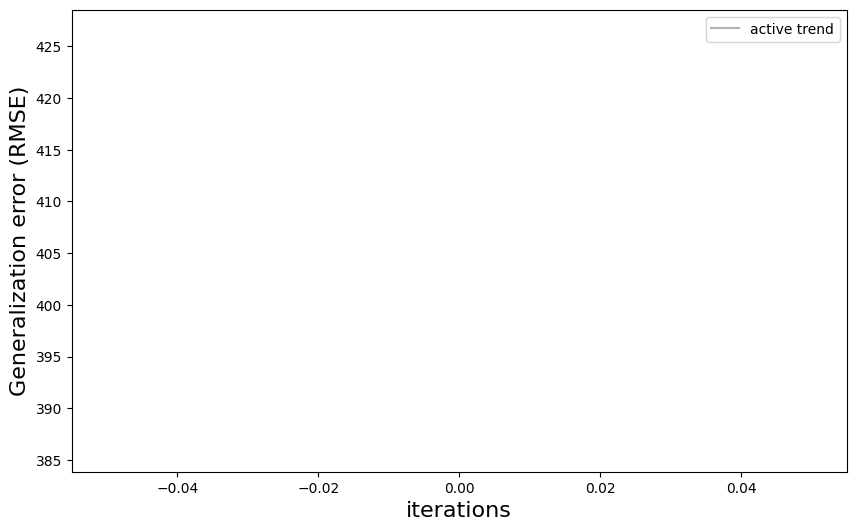

<Figure size 640x480 with 0 Axes>

In [67]:
# performance_passive = [389.08472357474653, 385.3519365843284, 384.9566122367074]
# x = range(0,5)

fontsize = 16
plt.figure(figsize=(10, 6))
# plt.plot(performance_passive, alpha=0.6, color='blue', label='passive trend')
plt.plot(performance, alpha=0.6,  color='grey', label='active trend')
# plt.title(title, fontsize=fontsize)
plt.xlabel('iterations', fontsize=fontsize)
plt.ylabel('Generalization error (RMSE)', fontsize=fontsize)
# plt.legend(fontsize=fontsize)
plt.grid(False)
plt.legend()
plt.show()
tmp = folder_path + 'active_learning_trend.png'
plt.savefig(tmp)

In [68]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
    
# Save datasets with specific path
def save_datasets(X, y, filename_prefix, run_directory, base_dir='/Users/KU1247/Desktop/active_learning_code/'):
    save_dir = f'{base_dir}{run_directory}/'
    np.save(f'{save_dir}{filename_prefix}_X.npy', X)
    np.save(f'{save_dir}{filename_prefix}_y.npy', y)

def save_model(model, model_name, run_directory, base_dir='/Users/KU1247/Desktop/active_learning_code/'):
    # Construct the full directory path
    save_dir = f'{base_dir}{run_directory}/'
    
    # Save the model
    model.save(f'{save_dir}{model_name}.h5')  # Saves the entire model
    print(f"Model saved successfully in {save_dir}")

# Example usage after your active learning loop
# Saving datasets
if(experiment == 'active'):
    save_datasets(X_labeled, y_labeled, 'active_labeled_dataset', folder_to)
    save_datasets(X_unlabeled, y_unlabeled, 'active_unlabeled_dataset', folder_to)
    save_model(model, 'active_learning_model', folder_to)
elif(experiment =='passive'):
    save_datasets(X_labeled, y_labeled, 'passive_labeled_dataset', folder_to)
    save_datasets(X_unlabeled, y_unlabeled, 'passive_unlabeled_dataset', folder_to)
    save_model(model, 'passive_learning_model', folder_to)
# Saving the model


# Example usage after your passive learning loop
# Saving datasets
# save_datasets(X_labeled_passive, y_labeled_passive, 'passive_labeled_dataset')
# save_datasets(X_unlabeled_passive, y_unlabeled_passive, 'passive_unlabeled_dataset')

# # Saving the model
# save_model(model_passive, 'passive_learning_model')


Model saved successfully in /Users/KU1247/Desktop/active_learning_code/past_runs/run9_passive/
